In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())


In [4]:
if "ENDPAD" not in words:
    words.append("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}




In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())
print("Unique tags are:", tags)


Unique words in corpus: 35177
Unique tags in corpus: 17
Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [6]:
class SentenceGetter:
    def __init__(self, data):
        self.grouped = data.groupby("Sentence #", group_keys=False).apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(self.grouped)

getter = SentenceGetter(data)
sentences = getter.sentences

sentences[35]


[('The', 'O'),
 ('U.S.', 'B-org'),
 ('Geological', 'I-org'),
 ('Survey', 'I-org'),
 ('gave', 'O'),
 ('a', 'O'),
 ('preliminary', 'O'),
 ('estimate', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('strength', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('Tuesday', 'B-tim'),
 ('morning', 'I-tim'),
 ('quake', 'O'),
 ('at', 'O'),
 ('6.7', 'O'),
 ('on', 'O'),
 ('the', 'O'),
 ('Richter', 'B-geo'),
 ('scale', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('said', 'O'),
 ('the', 'O'),
 ('epicenter', 'O'),
 ('was', 'O'),
 ('close', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 ('of', 'O'),
 ('Nias', 'B-org'),
 ('.', 'O')]

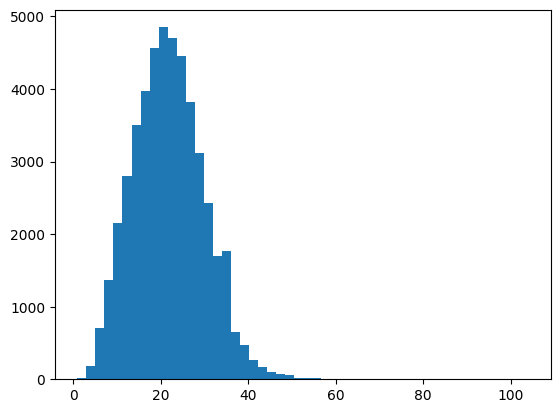

In [7]:
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

word2idx

plt.hist([len(s) for s in sentences], bins=50)
plt.show()


In [9]:
max_len = 50
X_pad = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=word2idx["ENDPAD"])
y_pad = pad_sequence([torch.tensor(seq) for seq in y], batch_first=True, padding_value=tag2idx["O"])
X_pad = X_pad[:, :max_len]
y_pad = y_pad[:, :max_len]
X_pad[0]
y_pad[0]


tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=1)


In [11]:
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32)

In [12]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=50, hidden_dim=100):
        super(BiLSTMTagger, self).__init__()
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.dropout=nn.Dropout(0.1)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, tagset_size)
    def forward(self,x):
        x=self.embedding(x)
        x=self.dropout(x)
        x,_=self.lstm(x)
        return self.fc(x)

In [13]:
model = BiLSTMTagger(len(word2idx)+1, len(tag2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss=0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs.view(-1, len(tag2idx)), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        train_losses.append(total_loss)
        model.eval()
        val_loss=0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids)
                loss = loss_fn(outputs.view(-1, len(tag2idx)), labels.view(-1))
                val_loss+=loss.item()
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss}, Val Loss: {val_loss}")
    return train_losses, val_losses

In [15]:
def evaluate_model(model, test_loader, X_test, y_test):
    model.eval()
    true_tags, pred_tags = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=-1)
            for i in range(len(labels)):
                for j in range(len(labels[i])):
                    if labels[i][j] != tag2idx["O"]:
                        true_tags.append(idx2tag[labels[i][j].item()])
                        pred_tags.append(idx2tag[preds[i][j].item()])


In [16]:
train_losses, val_losses = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3)
evaluate_model(model, test_loader, X_test, y_test)


Epoch 1/3, Train Loss: 254.45643089711666, Val Loss: 32.27267640829086
Epoch 2/3, Train Loss: 106.91323712468147, Val Loss: 22.375881005078554
Epoch 3/3, Train Loss: 79.47475546784699, Val Loss: 19.070536348968744


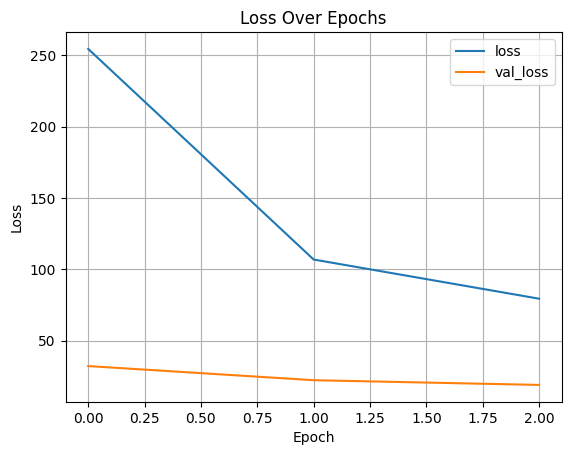

In [17]:
history_df = pd.DataFrame({"loss": train_losses, "val_loss": val_losses})
history_df.plot(title="Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [18]:
i = 125
model.eval()
sample = X_test[i].unsqueeze(0).to(device)
output = model(sample)
preds = torch.argmax(output, dim=-1).squeeze().cpu().numpy()
true = y_test[i].numpy()

In [19]:
print('Name: Marino Sarisha T')
print('Register Number: 212223240084')
print("{:<15} {:<10} {}\n{}".format("Word", "True", "Pred", "-" * 40))
for w_id, true_tag, pred_tag in zip(X_test[i], y_test[i], preds):
    if w_id.item() != word2idx["ENDPAD"]:
        word = words[w_id.item() - 1]
        true_label = tags[true_tag.item()]
        pred_label = tags[pred_tag]
        print(f"{word:<15} {true_label:<10} {pred_label}")


Name: Marino Sarisha T
Register Number: 212223240084
Word            True       Pred
----------------------------------------
Palestinian     B-gpe      B-gpe
officials       O          O
say             O          O
two             O          O
Palestinians    B-gpe      B-gpe
have            O          O
been            O          O
killed          O          O
in              O          O
an              O          O
accidental      O          O
explosion       O          O
in              O          O
a               O          O
West            B-org      B-org
Bank            I-org      I-org
refugee         O          O
camp            O          O
.               O          O
